# Twitter data exploration

In the previous notebook we scraped tweets mentioning Boris Johnson over 2019 and 2020. In this notebook we'll take a preliminary look at the dataset; how large is it, what some of the fields are like, and some common themes over time.

The main thing I want to see is a word cloud over different periods of time, just for a hint of what's coming in the next notebook (Topic Modelling). Notable dates: 2019-07-24 (Boris assumed office as Prime Minister), 2020-03-16 (first UK lockdown announced due to COVID-19 pandemic), and December 2020 (first vaccine rolled out in the UK).

In [1]:
%%capture
!pip install wordcloud
!pip install seaborn
!pip install nltk

## Explore Boris Johnson tweets data

In [2]:
import datetime
import os

Parse JSON tweets, saving as CSV.

In [3]:
from src.parsing import parse_directory, parse_list_of_files

In [4]:
import itertools
list_of_files = [
    'tweets_data/tweets_{0}-{1:0>2}-01.json'.format(x, y) 
    for x, y in itertools.product(['2019', '2020'], range(1, 13, 1))
]


parse_list_of_files(list_of_files, 'sample_of_2019_20.csv')

Done!


## Basic Exploratory Data Analysis

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 40

plt.style.use('seaborn')

In [6]:
df = pd.read_csv('sample_of_2019_20.csv')

In [7]:
print(df.shape)
df.sample(3)

(459839, 24)


,tweet_id,date,tweet_datetime,content,url,user,user_id,user_verified,user_created,user_description,user_location,user_followersCount,user_statusesCount,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,lang,sourceLabel,retweetedTweet,quotedTweet,n_mentionedUsers
16106,1145730019681087499,2019-07-01,2019-07-01T16:24:57+00:00,@DavidDavisMP @BorisJohnson All at the expense...,https://twitter.com/bobdeeuk/status/1145730019...,bobdeeuk,145324560,False,2010-05-18T17:50:01+00:00,Retired engineer. Centrist/Generalist. Lucky D...,"Bristol, UK",240,22454,[],[],0,0,7,0,en,Twitter for iPhone,NaN,NaN,2
25802,1157015292184317954,2019-08-01,2019-08-01T19:48:36+00:00,@Conservatives @BorisJohnson Brexit is a death...,https://twitter.com/PuzzleEUcat/status/1157015...,PuzzleEUcat,961889614675042304,False,2018-02-09T09:08:49+00:00,not really a cat but devoted to UK staying in ...,United Kingdom,2757,5484,[],[],0,0,1,0,en,Twitter for iPhone,NaN,NaN,2
16888,1145710521565552640,2019-07-01,2019-07-01T15:07:29+00:00,@EUFascismWatch @AnaOrsatti @SkyNews @PhilipHa...,https://twitter.com/PaulPsmith67/status/114571...,PaulPsmith67,168793075,False,2010-07-20T20:28:57+00:00,Gemini believe in equality hate racists,"Shrewsbury, England",85,11194,[],[],0,0,1,0,en,Twitter Web Client,NaN,NaN,5


In [8]:
df.isnull().mean()

tweet_id               0.000000
date                   0.000000
tweet_datetime         0.000000
content                0.000000
url                    0.000000
user                   0.000000
user_id                0.000000
user_verified          0.000000
user_created           0.000000
user_description       0.179926
user_location          0.323141
user_followersCount    0.000000
user_statusesCount     0.000000
outlinks               0.000000
tcooutlinks            0.000000
replyCount             0.000000
retweetCount           0.000000
likeCount              0.000000
quoteCount             0.000000
lang                   0.000000
sourceLabel            0.000015
retweetedTweet         1.000000
quotedTweet            0.903979
n_mentionedUsers       0.000000
dtype: float64

### Number of tweets over time

Number of tweets mentioning Boris Johnson increased significantly after he became Prime Minister from ~5000 per day to ~35,000 in the later half of 2019.

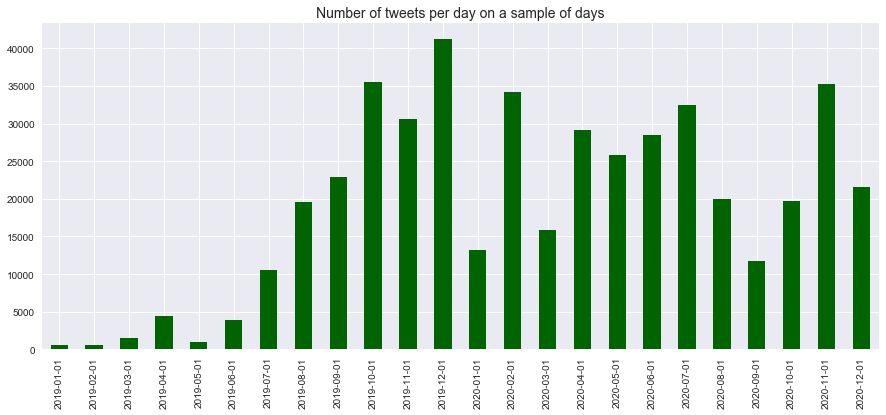

In [9]:
df['date_trunc'] = pd.to_datetime(df['tweet_datetime']).dt.strftime('%Y-%m-%d')

df['date_trunc'].value_counts().sort_index().plot(kind='bar', figsize=(15, 6), color='darkgreen')
plt.title('Number of tweets per day on a sample of days', fontsize=14)
plt.show()

We'll also plot the number of tweets over time for the whole dataset, but we can't load it all into memory, so we'll approximate it using the file size.

In [10]:
def get_file_size(file_loc):
    return os.path.getsize(file_loc) / 1000000

total_file_size = sum([get_file_size(file_loc) for file_loc in list_of_files])
total_num_tweets = len(df)
avg_tweets_per_mb = total_num_tweets/total_file_size

print('Avg. number of tweets per MB: {}'.format(avg_tweets_per_mb))

Avg. number of tweets per MB: 269.6297622209912


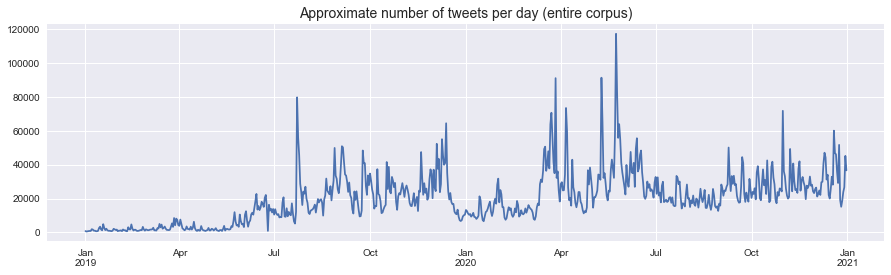

In [11]:
file_sizes = {
    datetime.datetime.strptime(file_loc.split('tweets_')[-1].split('.json')[0], '%Y-%m-%d'): 
        os.path.getsize('tweets_data/{}'.format(file_loc)) / 1000000
    for file_loc in os.listdir('tweets_data') if file_loc.endswith('.json')
}
file_sizes = pd.DataFrame(file_sizes, index=['size']).T
file_sizes['num_tweets_estimate'] = file_sizes['size'] * avg_tweets_per_mb

file_sizes['num_tweets_estimate'].T.plot(kind='line', figsize=(15, 4))
plt.title('Approximate number of tweets per day (entire corpus)', fontsize=14)
plt.savefig('images/tweets_per_day.png')
plt.show()

### Various tweet breakdowns

In [12]:
df['user_verified'].value_counts(normalize=True)

False    0.993385
True     0.006615
Name: user_verified, dtype: float64

Note that there must always be at least one user mentioned in the tweets in this dataset, since BoJo himself is mentioned!

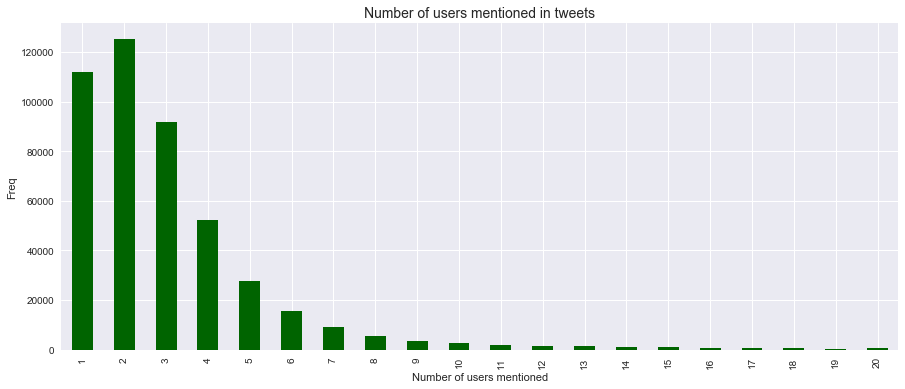

In [13]:
ax = df['n_mentionedUsers'].clip(0, 21).value_counts().sort_index().plot(kind='bar', figsize=(15, 6), color='darkgreen')
ax.set_xlim(0.5, 20.5)
ax.set_xlabel('Number of users mentioned')
ax.set_ylabel('Freq')
ax.set_title('Number of users mentioned in tweets', fontsize=14)
plt.show()

Most common user locations.

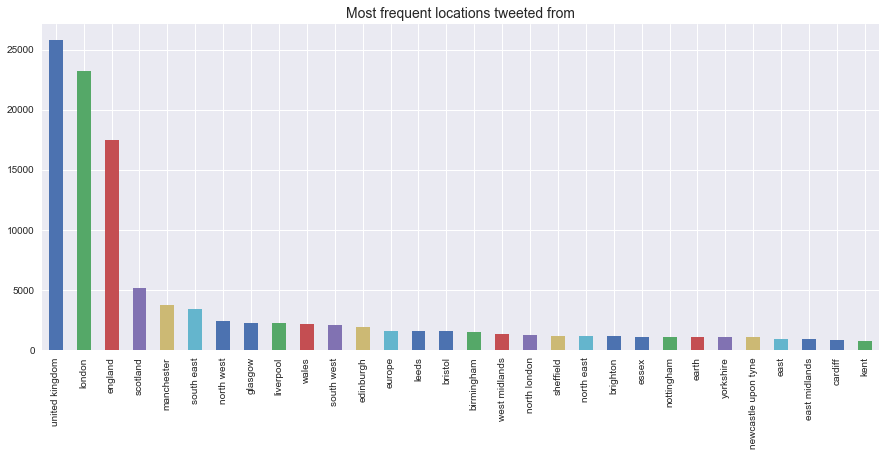

In [14]:
df['user_location'].str.lower()\
    .str.replace(', (uk|england|united kingdom|scotland|wales)', '', regex=True)\
    .str.replace('uk', 'united kingdom')\
    .value_counts().head(30)\
    .plot(kind='bar', figsize=(15,6))
plt.title('Most frequent locations tweeted from', fontsize=14)
plt.show()

In [15]:
print('Mean user followers count: {}'.format(round(df.user_followersCount.mean(), 2)))

Mean user followers count: 4090.69


Who tweeted Boris with the most followers?

In [16]:
df.loc[df.user_followersCount == df.user_followersCount.max(), 'user'].values[0]

'XHNews'

The top few:

In [17]:
list(df.sort_values('user_followersCount', ascending=False)['user'].head(200).unique()[:20])

['XHNews',
 'ABPNews',
 'TimesNow',
 'htTweets',
 'piersmorgan',
 'SkyNews',
 '10DowningStreet',
 'IndiaToday',
 'ZeeNews',
 'WRadioColombia',
 'KP24',
 'biobio',
 'BorisJohnson',
 'RandPaul',
 'Telegraph',
 'SecPompeo',
 'lajornadaonline',
 'sebastianpinera',
 'Franklin_Graham',
 'Channel4News']

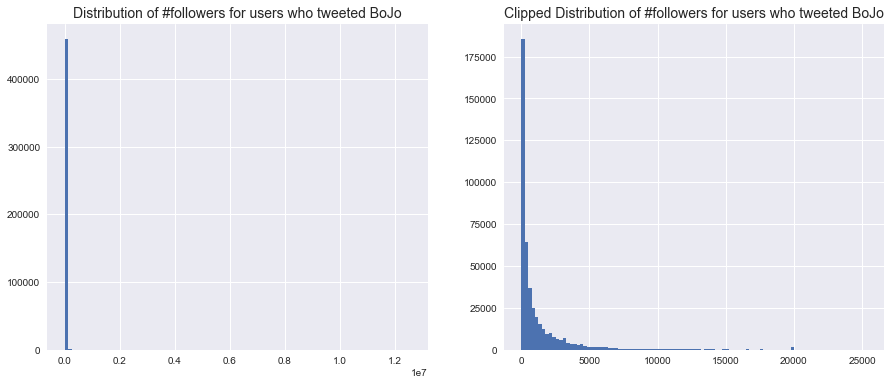

In [18]:
_, ax = plt.subplots(1, 2, figsize=(15,6))
df['user_followersCount'].hist(bins=100, ax=ax[0])
df.loc[df.user_followersCount <= df.user_followersCount.quantile(0.99), 'user_followersCount'].hist(bins=100, ax=ax[1])
ax[0].set_title('Distribution of #followers for users who tweeted BoJo', fontsize=14)
ax[1].set_title('Clipped Distribution of #followers for users who tweeted BoJo', fontsize=14)
plt.show()

## WordCloud for each quarter

We'll create a WordCloud for each quarter of tweets, so that we can view how the topics have changed since early 2019. This will give us an idea of what to expect before we begin our topic modelling exercise.

Utilities for processing the text.

In [19]:
import re
import nltk

stop_words = nltk.corpus.stopwords.words('english')
extra_stop_words = ['will', 'bori', 'boris', 'johnson']

def remove_special_parts(tweet_txt):
    return ' '.join(
        re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_txt.replace('&amp;', ' '))\
            .split()
    )

WordCloud utilities.

In [20]:
from wordcloud import WordCloud
import random

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(0, 50)


In [21]:
import datetime

quarters = {
    '2019 Q1': ('2019-01-01', '2019-03-31'),
    '2019 Q2': ('2019-04-01', '2019-06-30'),
    '2019 Q3': ('2019-07-01', '2019-09-30'),
    '2019 Q4': ('2019-10-01', '2019-12-31'),
    '2020 Q1': ('2020-01-01', '2020-03-31'),
    '2020 Q2': ('2020-04-01', '2020-06-30'),
    '2020 Q3': ('2020-07-01', '2020-09-30'),
    '2020 Q4': ('2020-10-01', '2020-12-31'),
}

def get_list_of_dates(sdate, edate):
    sdate = datetime.datetime.strptime(sdate, '%Y-%m-%d')
    edate = datetime.datetime.strptime(edate, '%Y-%m-%d')
    delta = edate - sdate
    dates = [sdate + datetime.timedelta(days=i) for i in range(delta.days + 1)]
    return [d.strftime('%Y-%m-%d') for d in dates]

Done!


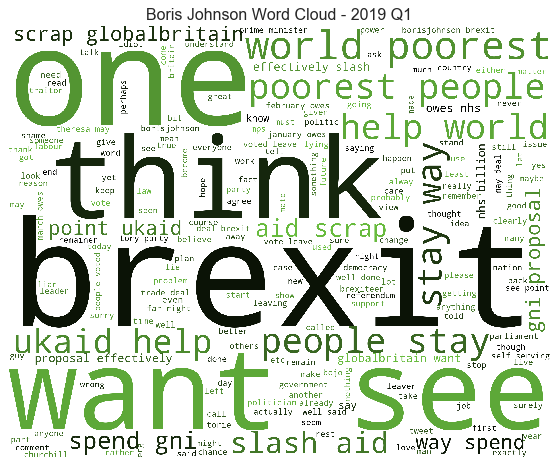

Done!


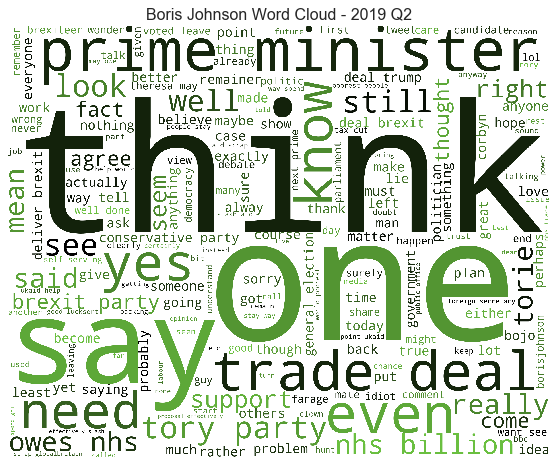

Done!


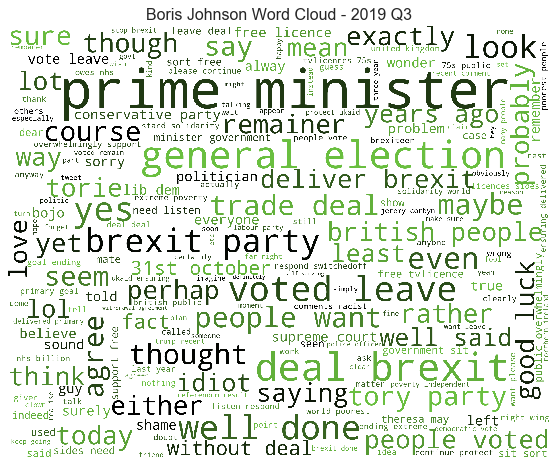

Done!


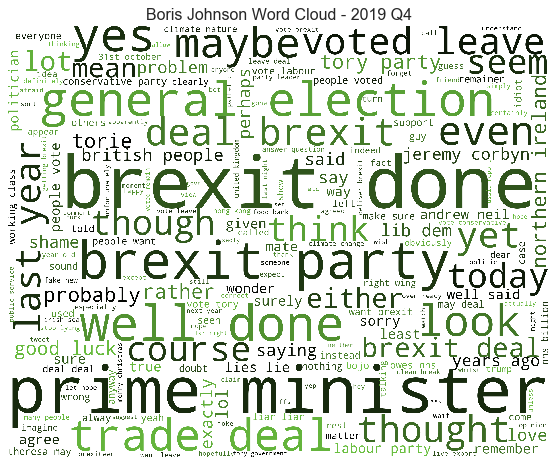

Done!


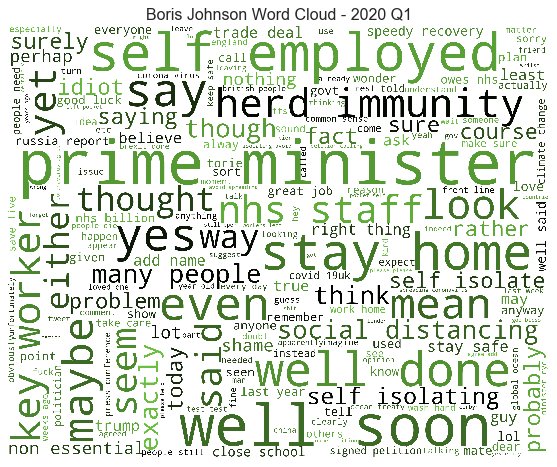

Done!


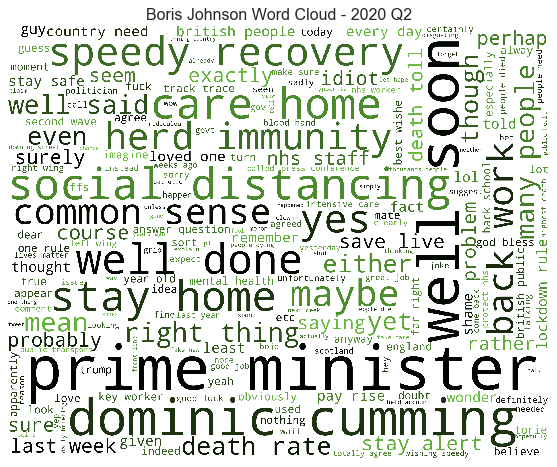

Done!


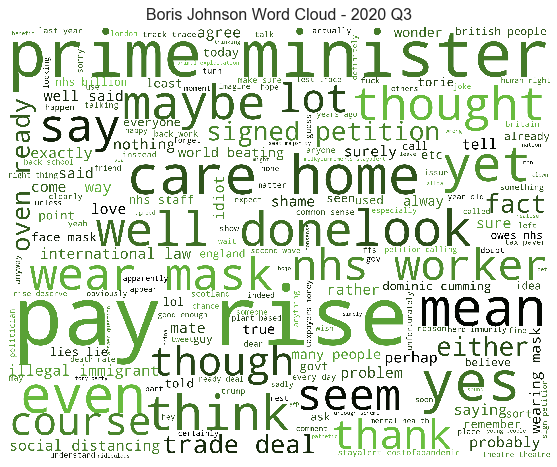

Done!


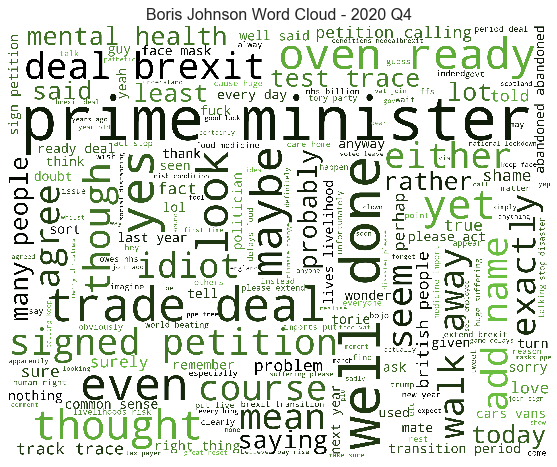

In [22]:
for quarter, quarter_dates in quarters.items():
    # Parse text, save as csv
    list_of_files = ['tweets_data/tweets_{}.json'.format(x) for x in get_list_of_dates(*quarter_dates)]
    parse_list_of_files(list_of_files, '{}.csv'.format(quarter.replace(' ', '')))
    
    # Reload csv, perform analysis
    df = pd.read_csv('{}.csv'.format(quarter.replace(' ', '')))
    df['date_trunc'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df['processed_txt'] = df['content'].str.lower().apply(remove_special_parts)
    
    entire_text = ' '.join([x for x in df['processed_txt'].values])
    entire_text = ' '.join([x for x in entire_text.split() if x not in stop_words+extra_stop_words])
    
    wc = WordCloud(
        background_color="white", 
        max_words=200, width=1000, height=800, 
        collocation_threshold=10,
        min_word_length=3,
        scale=3,
        min_font_size=10
    ).generate(
        entire_text
    )

    wc.recolor(color_func=green_color_func, random_state=1)
    plt.figure(figsize=(18, 8), facecolor=None) 
    plt.imshow(wc) 

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.title('Boris Johnson Word Cloud - {}'.format(quarter), fontsize=16)
    plt.savefig('images/WordCloud_{}.png'.format(quarter.replace(' ', '')))
    plt.show()


In [23]:
df['date'].agg(['min', 'max'])

min    2020-10-01
max    2020-12-31
Name: date, dtype: object

Overall we have around 14.6 million tweets in this dataset.

In [24]:
file_nrows = [pd.read_csv("{}.csv".format(quarter.replace(' ', '')), usecols=[0]).shape[0] for quarter in quarters.keys()]

In [25]:
sum(file_nrows)

14627641